# TechNova Attrition Analysis - Prédisez et comprenez le turnover des employés.

<div align="left">
  <img src="../docs/images/logo_technova.png" width="200px" alt="Logo TechNova Partners">
</div>

## **Objectif**: Identifier les causes racines de l'attrition et prédire le départ des collaborateurs à l'aide de **XGBoost** et **SHAP**.

# <span style="color:red"> 🔍 Étape 1 - Effectuez une analyse exploratoire des fichiers de données</span>


Sans surprise, la première chose à faire serait de mener une <span style="color:red">analyse exploratoire des différents fichiers pour faire ressortir des différences clés</span> entre les employés ayant quitté l’entreprise et ceux qui y sont encore. Ce seront des insights importants à formaliser pour les RH !

Pour te faciliter les choses, nous avons pu compiler 3 fichiers de données, chacun issu d’une source différente :

* **extrait_sirh.csv**: Un **extrait de notre système SIRH** où l’on va trouver des informations sur la fonction qu’occupe un employé chez nous  ainsi que son âge, salaire, ancienneté etc.) ainsi que ses informations sociodémographiques.

* **extrait_eval.csv**: **Un extrait d’un autre SI** que l’on utilise spécifiquement pour les **évaluations annuelles de performance**. On y retrouve des informations telles que les notes de ces évaluations et des notes de satisfaction données par les employés.

* **extrait_sondage.csv**: Enfin, nous demandons aussi à tous nos employés de remplir **annuellement un sondage** qui nous aide à mettre en place des actions pour le bien-être des employés. Voici à disposition l’extrait du sondage le plus récent. Nous y avons ajouté un <span style="color:red">témoin pour indiquer si l’employé a quitté l’entreprise ou non</span>.


# ⬇️ IMPORTATION DES LIBRAIRIES (STACK DE SCIENCE DES DONNÉES)

In [49]:
import pandas as pd
from pathlib import Path
from ydata_profiling import ProfileReport

# ⚙️ CONFIGURATION GLOBALE DU PROJET

In [50]:
# Configuration des chemins
RAW_DATA_DIR     = Path("../data/raw")
INTERIM_DATA_DIR = Path("../data/interim")
REPORTS_DIR      = Path("../reports")

NB_OBSERVATIONS_SIRH_RAW    = None
NB_FEATURES_SIRH_RAW        = None

NB_OBSERVATIONS_EVALS_RAW   = None
NB_FEATURES_EVALS_RAW       = None

NB_OBSERVATIONS_SONDAGE_RAW = None
NB_FEATURES_SONDAGE_RAW     = None


# Étape 1 : Analyse Exploratoire des Données (EDA)

## ❇️ LOAD AND EXPLORE DATASET

In [51]:
# 1. Chargement des fichiers
df_sirh    = pd.read_csv(RAW_DATA_DIR / "extrait_sirh.csv")
df_evals   = pd.read_csv(RAW_DATA_DIR / "extrait_eval.csv")
df_sondage = pd.read_csv(RAW_DATA_DIR / "extrait_sondage.csv")

RAW_DATASETS = {
    "SIRH"        : df_sirh,
    "Évaluations" : df_evals,
    "Sondage"     : df_sondage
}

# On garde les dimensions initials.
NB_OBSERVATIONS_SIRH_RAW,    NB_FEATURES_SIRH_RAW    = df_sirh.shape
NB_OBSERVATIONS_EVALS_RAW,   NB_FEATURES_EVALS_RAW   = df_evals.shape
NB_OBSERVATIONS_SONDAGE_RAW, NB_FEATURES_SONDAGE_RAW = df_sondage.shape

# Audit rapide des colonnes et des identifiants
print("\n==================================================================================================")
print(f"SIRH shape........: {NB_OBSERVATIONS_SIRH_RAW} employés \n")
print(f"SIRH features.....: {NB_FEATURES_SIRH_RAW}  \n")
df_sirh.info()
print("\n==================================================================================================")
print(f"EVALS shape........: {NB_OBSERVATIONS_EVALS_RAW} évaluations \n")
print(f"SIRH features......: {NB_FEATURES_EVALS_RAW}  \n")
df_evals.info()
print("\n==================================================================================================")
print(f"SONDAGE shape......: {NB_OBSERVATIONS_SONDAGE_RAW} réponses \n")
print(f"SIRH features......: {NB_FEATURES_SONDAGE_RAW}  \n")
df_sondage.info()

print("\n==================================================================================================")
print(f"TOTAL features.....: {NB_FEATURES_SIRH_RAW + NB_FEATURES_EVALS_RAW + NB_FEATURES_SONDAGE_RAW  }  \n")



SIRH shape........: 1470 employés 

SIRH features.....: 12  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_dans_l_entreprise        1470 non-null   int64 
 11  annees_dans_le_poste_actuel     1470 non-null

### 🍃 Identifier le témoin pour indiquer si l’employé a quitté l’entreprise ou non.

In [52]:
HAS_LEFT = 'a_quitte_l_entreprise'

### 🔍︎ Verification & Audit. Chargement avec Pandas et vérification des types 

In [53]:
for name, df in RAW_DATASETS.items():
    print("\n==================================================================================================")
    print(f"\n--- Audit du dataset : {name} ---")
    print(f"Dimensions : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    print(f"Colonnes clés : {df.columns.tolist()[:5]}...") # Aperçu des premières colonnes
    print(df.info())                                       # Vérification des types Dtype (int, float, object)
    display(df.head(3))                                    # Visualisation des premières lignes



--- Audit du dataset : SIRH ---
Dimensions : 1470 lignes, 12 colonnes
Colonnes clés : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_employee                     1470 non-null   int64 
 1   age                             1470 non-null   int64 
 2   genre                           1470 non-null   object
 3   revenu_mensuel                  1470 non-null   int64 
 4   statut_marital                  1470 non-null   object
 5   departement                     1470 non-null   object
 6   poste                           1470 non-null   object
 7   nombre_experiences_precedentes  1470 non-null   int64 
 8   nombre_heures_travailless       1470 non-null   int64 
 9   annee_experience_totale         1470 non-null   int64 
 10  annees_da

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0




--- Audit du dataset : Évaluations ---
Dimensions : 1470 lignes, 10 colonnes
Colonnes clés : ['satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   satisfaction_employee_environnement        1470 non-null   int64 
 1   note_evaluation_precedente                 1470 non-null   int64 
 2   niveau_hierarchique_poste                  1470 non-null   int64 
 3   satisfaction_employee_nature_travail       1470 non-null   int64 
 4   satisfaction_employee_equipe               1470 non-null   int64 
 5   satisfaction_employee_equilibre_pro_perso  1470 non-null   int64 
 6   eval_number                                1470 non

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %




--- Audit du dataset : Sondage ---
Dimensions : 1470 lignes, 12 colonnes
Colonnes clés : ['a_quitte_l_entreprise', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'code_sondage']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   a_quitte_l_entreprise                1470 non-null   object
 1   nombre_participation_pee             1470 non-null   int64 
 2   nb_formations_suivies                1470 non-null   int64 
 3   nombre_employee_sous_responsabilite  1470 non-null   int64 
 4   code_sondage                         1470 non-null   int64 
 5   distance_domicile_travail            1470 non-null   int64 
 6   niveau_education                     1470 non-null   int64 
 7   domaine_etude                        1470 non-null   object
 8   ayant_enfa

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0


### Generer des rapports (ydata profiling)

In [54]:
def create_single_report(df, report_name, title, reports_dir, force_update=False):
    """
    Tâche atomique : Génère un rapport à partir d'un objet DataFrame.
    """
    reports_dir = Path(reports_dir)
    reports_dir.mkdir(exist_ok=True)
    report_path = reports_dir / f"{report_name}.html"

    if report_path.exists() and not force_update:
        print(f"✅ Rapport déjà présent : {report_name}")
        return

    print(f"🚀 Génération du rapport : {title}...")
    profile = ProfileReport(df, title=title, explorative=True, html={"style": {"full_width": True}})
    profile.to_file(report_path)
    print(f"✨ Sauvegardé : {report_path}")
    
def generate_profile_reports(file_list, raw_dir, reports_dir, force_update=False):
    """
    Genera informes de profiling para una lista de archivos CSV si no existen.
    """
    raw_dir      = Path(raw_dir)
    reports_dir  = Path(reports_dir)
    reports_dir.mkdir(exist_ok=True)

    for file_name in file_list:
            file_path = Path(raw_dir) / file_name
            if file_path.exists():
                df = pd.read_csv(file_path)
                create_single_report(
                    df, 
                    report_name=f"report_{file_path.stem}", 
                    title=f"Profiling - {file_name}", 
                    reports_dir=reports_dir, 
                    force_update=force_update
                )

FICHIERS_RAW = ["extrait_sirh.csv", "extrait_eval.csv", "extrait_sondage.csv"]
    
generate_profile_reports(
    file_list   = FICHIERS_RAW,
    raw_dir     = RAW_DATA_DIR,
    reports_dir = REPORTS_DIR
)

✅ Rapport déjà présent : report_extrait_sirh
✅ Rapport déjà présent : report_extrait_eval
✅ Rapport déjà présent : report_extrait_sondage


## 🔗 Consolidation (Merge) : Fusion des trois sources autour de l'identifiant unique de l'employé.

### 1. Identification des IDs

Des cellules au sein du notebook pour calculer des statistiques descriptives sur les fichiers de départ et le fichier central, dans l’objectif de faire ressortir des différences clés entre les employés.

In [55]:
# Pour 'code_sondage', on nettoie d'abord les zéros pour comparer des nombres
sondage_ids = df_sondage['code_sondage'].astype(int)
print(sondage_ids.describe())

count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: code_sondage, dtype: float64


In [56]:
# Comparer les statistiques descriptives des IDs potentiels
print(df_sirh['id_employee'].describe())

count    1470.000000
mean     1024.865306
std       602.024335
min         1.000000
25%       491.250000
50%      1020.500000
75%      1555.750000
max      2068.000000
Name: id_employee, dtype: float64


In [57]:
# Extraction des chiffres et conversion en numérique pour un vrai describe()
# Note le 'r' avant les guillemets
eval_numeric = df_evals['eval_number'].str.extract(r'(\d+)').astype(int)
print("Statistiques de l'ID numérique dans EVALS :")
print(eval_numeric.describe())

Statistiques de l'ID numérique dans EVALS :
                 0
count  1470.000000
mean   1024.865306
std     602.024335
min       1.000000
25%     491.250000
50%    1020.500000
75%    1555.750000
max    2068.000000


### 2. Nettoyage des IDs dans chaque DataFrame

In [58]:
# A. SIRH : Déjà numérique, mais nous assurons la cohérence en string
df_sirh['id'] = df_sirh['id_employee'].astype(str).str.strip()

# B. EVAL : Supprimer le préfixe 'E_'
# Nous utilisons .str.replace pour isoler le numéro
df_evals['id'] = df_evals['eval_number'].astype(str).str.replace('E_', '', regex=False).str.strip()

# C. SONDAGE : Supprimer les zéros non significatifs à gauche
# .lstrip('0') retire les '0' au début de la chaîne
df_sondage['id'] = df_sondage['code_sondage'].astype(str).str.lstrip('0').str.strip()


### 3. La Grande Fusion (The Master Merge)

In [59]:
# Fusion du SIRH avec les Évaluations
df_temp = pd.merge(df_sirh, df_evals, on='id', how='inner')

loss = len(df_sirh) - len(df_temp)
print(f"Données perdues lors de la fusion en df_temp : {loss}")

# Fusion du résultat avec le Sondage
df_merged = pd.merge(df_temp, df_sondage, on='id', how='inner')

loss = len(df_temp) - len(df_merged)
print(f"Données perdues lors de la fusion en df_merged : {loss}")

print(f"✅ Fusion terminée. Dimensions finales : {df_merged.shape}")

Données perdues lors de la fusion en df_temp : 0
Données perdues lors de la fusion en df_merged : 0
✅ Fusion terminée. Dimensions finales : (1470, 35)


### 🔍︎ Verification & Audit. 

In [60]:
# Vérification immédiate
print("\n==================================================================================================")
print(f"\n--- Audit du dataset : {name} ---")
print(f"Dimensions : {df_merged.shape[0]} lignes, {df_merged.shape[1]} colonnes")
print(f"Colonnes clés : {df_merged.columns.tolist()[:5]}...") # Aperçu des premières colonnes
print(df_merged.info())                                       # Vérification des types Dtype (int, float, object)
display(df_merged.head(3))      



--- Audit du dataset : Sondage ---
Dimensions : 1470 lignes, 35 colonnes
Colonnes clés : ['id_employee', 'age', 'genre', 'revenu_mensuel', 'statut_marital']...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   id_employee                                1470 non-null   int64 
 1   age                                        1470 non-null   int64 
 2   genre                                      1470 non-null   object
 3   revenu_mensuel                             1470 non-null   int64 
 4   statut_marital                             1470 non-null   object
 5   departement                                1470 non-null   object
 6   poste                                      1470 non-null   object
 7   nombre_experiences_precedentes             1470 non-null   int64 
 8   nombre_heures_tr

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3,1,4,2,2,Autre,Y,Occasionnel,0,0


### 📊 Generer un Repport sur la consolidaion

In [61]:
# 2. Générer le rapport du merge
create_single_report(
    df           = df_merged,
    report_name  = "report_FINAL_MERGED",
    title        = "Analyse Globale TechNova - Dataset Fusionné",
    reports_dir  =  REPORTS_DIR
)

✅ Rapport déjà présent : report_FINAL_MERGED


## 🔍︎ Analyse Comparative : Visualisation des segments "Restants" vs "Démissionnaires" (Attrition).

Nous devons transformer les données brutes en connaissances visuelles

### 1. Préparation de la cible (Target Cleaning)

In [62]:
# Conversion en binaire pour les calculs (1 = Parti, 0 = Resté)
df_merged['attrition_binary'] = df_merged['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})
print(df_merged['attrition_binary'].describe())

count    1470.000000
mean        0.161224
std         0.367863
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: attrition_binary, dtype: float64


### 2. Analyse du "Taux de Départ" (Le Chiffre Clé)

In [72]:
attrition_rate = df_merged['a_quitte_l_entreprise'].value_counts(normalize=True) * 100
print(f"Taux d'attrition global : {attrition_rate['Oui']:.2f}%")

Taux d'attrition global : 16.12%


### 3. Visualisations Comparatives (Insights)

Nous allons utiliser **Seaborn** pour comparer le profil des démissionnaires. Voici les trois graphiques indispensables :

* **A. Âge vs Attrition** : Est-ce que ce sont les jeunes qui partent ?
* **B. Salaire vs Attrition** : Le salaire est-il le facteur principal ?
* **C. Équilibre Pro/Perso vs Attrition** : La culture d'entreprise est-elle en cause ?

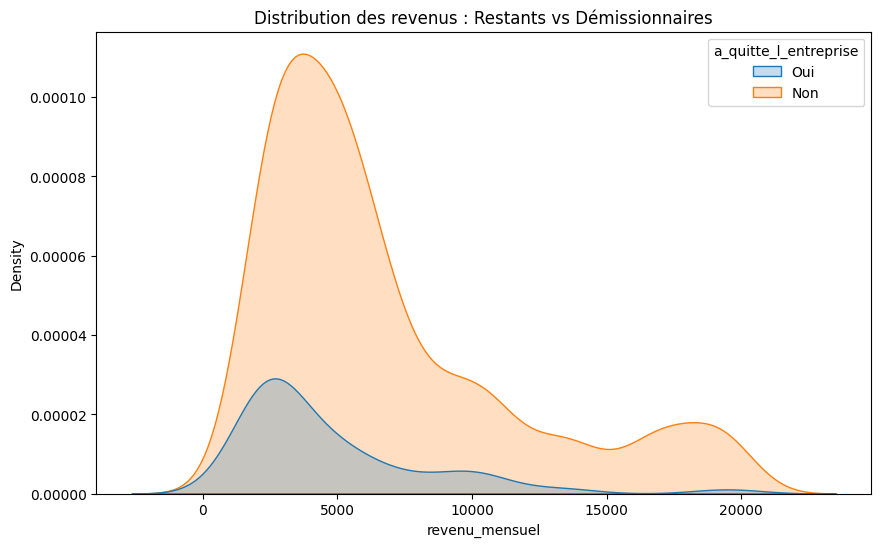

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exemple : Distribution du revenu mensuel par statut d'attrition
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_merged, x='revenu_mensuel', hue='a_quitte_l_entreprise', fill=True)
plt.title('Distribution des revenus : Restants vs Démissionnaires')
plt.show()

📊 Comment interpréter ton graphique ?

Voici l'analyse "Expert" de ce que tu vois :

1. **Le pic (Mode)** : On voit que pour les deux groupes, la plus grande concentration d'employés se situe autour de **2 500 - 4 000** de revenu mensuel.
2. **La queue de distribution** : Les employés qui restent ("Non") ont une courbe orange qui s'étend beaucoup plus vers la droite (les hauts salaires entre 15 000 et 20 000).
3. **L'insight critique** : La courbe bleue ("Oui") s'écrase presque totalement après 10 000. **Conclusion visuelle :** Presque personne ne démissionne chez TechNova s'il gagne plus de 10 000. L'attrition est un phénomène de "bas salaires".

Voir le nombre d employés !

Pour voir les volumes réels sur les effectifs, on utilise un Histogramme avec l'argument multiple="stack" ou element="step".

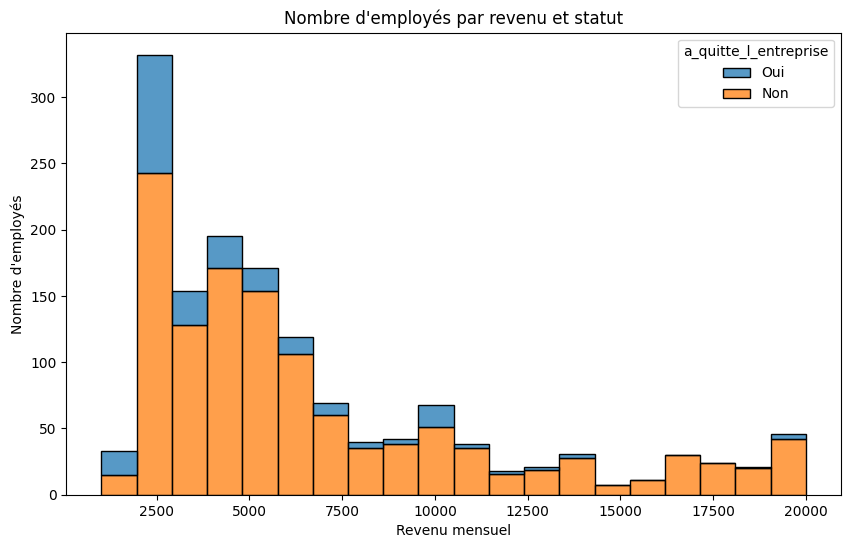

In [65]:

plt.figure(figsize=(10, 6))
# On utilise histplot au lieu de kdeplot
sns.histplot(data=df_merged, x='revenu_mensuel', hue='a_quitte_l_entreprise', 
             multiple="stack", palette="tab10")

plt.title('Nombre d\'employés par revenu et statut')
plt.ylabel('Nombre d\'employés')
plt.xlabel('Revenu mensuel')
plt.show()

In [66]:
# Groupe par Attrition pour comparer les moyennes
stats_compare = df_merged.groupby('a_quitte_l_entreprise').agg({
    'revenu_mensuel': ['mean', 'median'],
    'age': 'mean',
    'distance_domicile_travail': 'mean',
    'note_evaluation_actuelle': 'mean',
    'satisfaction_employee_environnement': 'mean'
}).round(2)

display(stats_compare)

revenu_mensuel            age distance_domicile_travail  \
                                mean  median   mean                      mean   
a_quitte_l_entreprise                                                           
Non                          6832.74  5204.0  37.56                      8.92   
Oui                          4787.09  3202.0  33.61                     10.63   

                      note_evaluation_actuelle  \
                                          mean   
a_quitte_l_entreprise                            
Non                                       3.15   
Oui                                       3.16   

                      satisfaction_employee_environnement  
                                                     mean  
a_quitte_l_entreprise                                      
Non                                                  2.77  
Oui                                                  2.46

#### Le facteur financier (Revenu mensuel)

C'est souvent le premier suspect. Le Boxplot est l'outil idéal ici car il montre la médiane, les quartiles et les valeurs aberrantes (outliers).

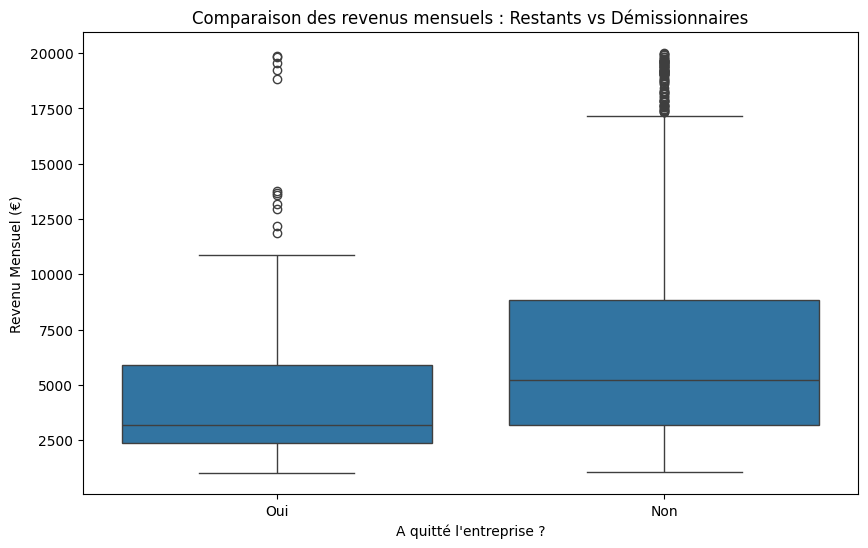

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='a_quitte_l_entreprise', y='revenu_mensuel')
plt.title('Comparaison des revenus mensuels : Restants vs Démissionnaires')
plt.xlabel('A quitté l\'entreprise ?')
plt.ylabel('Revenu Mensuel (€)')
plt.show()

#### L'équilibre Vie Pro / Vie Perso

Le fichier EVALS contient une note de satisfaction sur l'équilibre. Utilisons un graphique à barres empilées pour voir la proportion de départs par niveau de satisfaction.

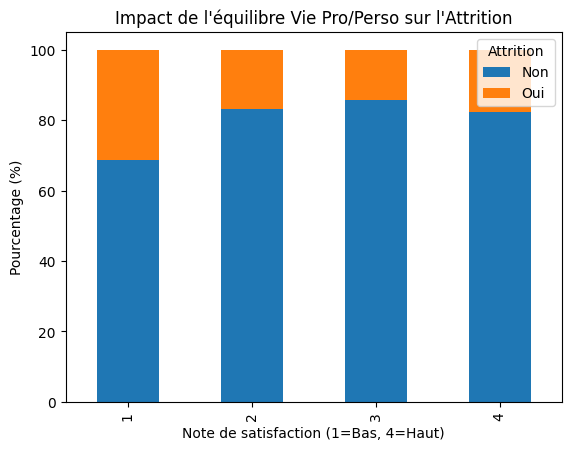

In [68]:
# Tableau croisé normalisé pour voir les proportions
equilibre_pivot = pd.crosstab(df_merged['satisfaction_employee_equilibre_pro_perso'], 
                              df_merged['a_quitte_l_entreprise'], 
                              normalize='index') * 100

equilibre_pivot.plot(kind='bar', stacked=True)
plt.title('Impact de l\'équilibre Vie Pro/Perso sur l\'Attrition')
plt.ylabel('Pourcentage (%)')
plt.xlabel('Note de satisfaction (1=Bas, 4=Haut)')
plt.legend(title='Attrition', loc='upper right')
plt.show()

####  L'impact des Heures Supplémentaires

C'est souvent une variable prédictive très forte pour les modèles XGBoost. Comparons le volume d'employés qui font des heures sup selon leur statut.

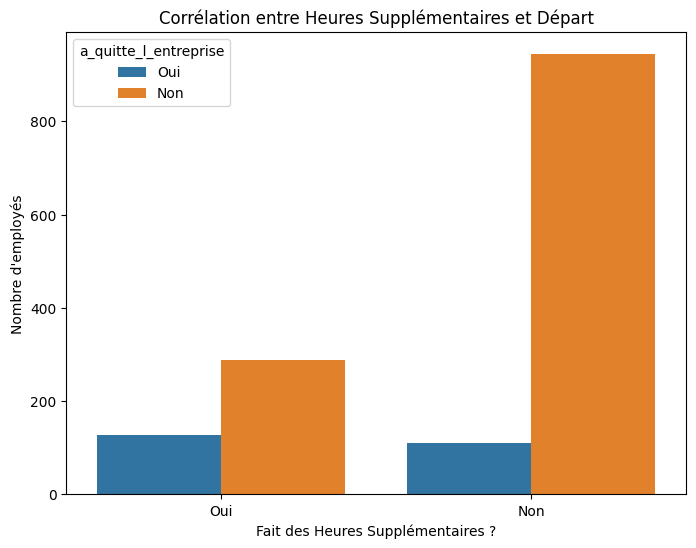

In [69]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_merged, x='heure_supplementaires', hue='a_quitte_l_entreprise')
plt.title('Corrélation entre Heures Supplémentaires et Départ')
plt.xlabel('Fait des Heures Supplémentaires ?')
plt.ylabel('Nombre d\'employés')
plt.show()

## 🚀 Dernière étape de l'EDA : Sauvegarde du Master Dataset
Une fois que on a exploré visuellement vos données, il faut figer ce travail :

In [70]:
# Sauvegarde dans data/interim avant le Feature Engineering (Étape 2)
df_merged.to_parquet(INTERIM_DATA_DIR / "df_merged_eda.parquet")